In [1]:
#@title Reading the files


In [1]:
import pandas as pd
import numpy as np
import os
from google.colab import drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#reading all files from the directory
path = '/content/drive/Shareddrives/AML_Project/Longitudinal'
file_list =[]

for filename in os.listdir(path):
  if filename.endswith(".csv"):
    filepath = os.path.join(path, filename)
    file_list.append(filepath)

file_list

['/content/drive/Shareddrives/AML_Project/Longitudinal/KB2.csv',
 '/content/drive/Shareddrives/AML_Project/Longitudinal/KB1.csv',
 '/content/drive/Shareddrives/AML_Project/Longitudinal/KB3.csv',
 '/content/drive/Shareddrives/AML_Project/Longitudinal/KB5.csv',
 '/content/drive/Shareddrives/AML_Project/Longitudinal/KB4.csv',
 '/content/drive/Shareddrives/AML_Project/Longitudinal/19.csv',
 '/content/drive/Shareddrives/AML_Project/Longitudinal/20.csv',
 '/content/drive/Shareddrives/AML_Project/Longitudinal/KB6.csv',
 '/content/drive/Shareddrives/AML_Project/Longitudinal/27.csv',
 '/content/drive/Shareddrives/AML_Project/Longitudinal/28.csv',
 '/content/drive/Shareddrives/AML_Project/Longitudinal/29.csv',
 '/content/drive/Shareddrives/AML_Project/Longitudinal/31.csv',
 '/content/drive/Shareddrives/AML_Project/Longitudinal/30.csv',
 '/content/drive/Shareddrives/AML_Project/Longitudinal/40.csv',
 '/content/drive/Shareddrives/AML_Project/Longitudinal/41.csv',
 '/content/drive/Shareddrives/AML_

In [4]:
#making list of all dataframes
data_all = []

for files in file_list:
  data = pd.read_csv(files)
  df = pd.DataFrame(data)
  data_all.append(df)

In [5]:
#making the final dataframe
df_all = pd.concat(data_all)
df_all.shape

(778752, 25)

In [6]:
#@title Dropping the unnecessary features


In [7]:
#sort for occupied = 1, schoolday = 1, usabilitymask = true
df_sort = df_all[(df_all['Occupied'] == 1) & (df_all['SchoolDay'] == 1) & (df_all['UsabilityMask'].__eq__(True))]
df_sort.shape

(46492, 25)

In [8]:
#drop columns timestamp, year, month, dayofyear, occupied, schoolday, hour, lessonnumber, lessonpct, usabilitymask
df_drop = df_sort.drop(['Year', 'Month', 'DayOfYear', 'Occupied', 'SchoolDay', 'Hour', 'LessonNumber', 'LessonPct', 'UsabilityMask'], axis=1)
df_drop = df_drop.iloc[:, 1:]
df_drop.shape

(46492, 15)

In [9]:
#@title Dividing into two datasets
#One for binary predictions on cooling behavior (no action = 0, cooling on = 1) 
#Another for binary on heating behavior (no action = 0, heating on = 1)

In [10]:
#dataframe for cooling by dropping heatingstate
df_cool = df_drop.drop(['HeatingState'], axis=1)
df_cool.head()

,IndoorTemperature,IndoorHumidity,IndoorCO2,IndoorNoise,OutdoorTemperature,OutdoorHumidity,OutdoorDewpoint,OutdoorWindDirection,OutdoorWindSpeed,OutdoorGustSpeed,Precipitation,UvLevel,SolarRadiation,CoolingState
394,15.4,59.0,524.0,74.0,9.195,87.0,7.250,135.0,1.45,2.05,0.20,0.0,40.50,0
395,15.5,59.0,649.0,68.0,9.165,86.0,6.970,135.0,1.80,2.45,0.10,0.0,44.20,0
396,15.5,59.0,649.0,68.0,9.165,87.0,7.110,225.0,1.40,1.95,0.10,1.0,88.20,0
397,15.6,60.0,747.0,59.0,9.225,88.0,7.305,180.0,1.20,1.80,0.05,1.0,121.85,0
398,15.8,60.0,879.0,50.0,9.275,87.5,7.305,135.0,0.90,1.35,0.00,1.5,170.50,0


In [11]:
#checking for imbalance
df_cool['CoolingState'].value_counts()

0    43098
1     3394
Name: CoolingState, dtype: int64

In [12]:
#dataframe for heating by dropping coolingstate
df_heat = df_drop.drop(['CoolingState'], axis=1)
df_heat.head()

,IndoorTemperature,IndoorHumidity,IndoorCO2,IndoorNoise,OutdoorTemperature,OutdoorHumidity,OutdoorDewpoint,OutdoorWindDirection,OutdoorWindSpeed,OutdoorGustSpeed,Precipitation,UvLevel,SolarRadiation,HeatingState
394,15.4,59.0,524.0,74.0,9.195,87.0,7.250,135.0,1.45,2.05,0.20,0.0,40.50,0
395,15.5,59.0,649.0,68.0,9.165,86.0,6.970,135.0,1.80,2.45,0.10,0.0,44.20,0
396,15.5,59.0,649.0,68.0,9.165,87.0,7.110,225.0,1.40,1.95,0.10,1.0,88.20,0
397,15.6,60.0,747.0,59.0,9.225,88.0,7.305,180.0,1.20,1.80,0.05,1.0,121.85,0
398,15.8,60.0,879.0,50.0,9.275,87.5,7.305,135.0,0.90,1.35,0.00,1.5,170.50,0


In [13]:
#checking for imbalance
df_heat['HeatingState'].value_counts()

0    45019
1     1473
Name: HeatingState, dtype: int64

In [14]:
#@title Applying GMMs to balance the cooling dataset

In [15]:
#test train split the cooling dataset
from sklearn.model_selection import train_test_split
X_cool = df_cool.iloc[:, :-1]
y_cool = df_cool['CoolingState']

X_train_cool, X_test_cool, y_train_cool, y_test_cool = train_test_split(X_cool, y_cool, test_size=0.2, shuffle=True)

In [16]:
#applying GMMs to balance cooling dataset
from sklearn.mixture import GaussianMixture

lowest_aic = np.infty
aic = []
n_components_range = range(1, 10)

for n_components in n_components_range:
        # Fit a Gaussian mixture with component range
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(X_train_cool)
        aic.append(gmm.aic(X_train_cool))
        if aic[-1] < lowest_aic:
            lowest_aic = aic[-1]
            best_gmm = gmm

print(lowest_aic)
print(best_gmm.n_components)

2253661.748765287
9


In [17]:
#checking the 9 clusters
gmm = GaussianMixture(9)
gmm.fit(X_train_cool)
pd.DataFrame(gmm.means_.T)

,0,1,2,3,4,5,6,7,8
0,21.839103,19.710092,24.380975,18.655154,24.599982,20.286549,23.369975,20.569840,22.625181
1,55.644008,55.936461,51.057191,60.338604,46.718048,59.447684,51.197750,64.267572,67.109850
2,1616.461246,836.942744,3611.546054,1757.946711,1855.880278,2160.381111,1344.456494,1200.126726,2071.136294
3,56.134526,53.602304,55.283026,57.552670,57.435840,59.508204,56.667932,56.943663,59.139389
4,22.470240,16.714465,28.871231,13.102556,32.070719,16.100578,27.791836,16.910564,18.710319
5,46.707901,62.052531,36.924053,79.817878,20.639635,68.447755,35.148571,83.508513,93.306265
6,10.411531,9.375111,10.781131,9.664857,6.288407,10.235137,10.893382,14.060891,17.607133
7,193.246799,217.852717,214.398984,211.408891,102.698114,195.087068,62.771483,229.488356,236.191390
8,1.944221,2.407831,1.940032,2.491190,2.978438,1.816428,2.153942,2.037080,1.614582
9,2.720169,3.292517,2.693310,3.415921,4.170492,2.491189,3.138213,2.701475,2.166279


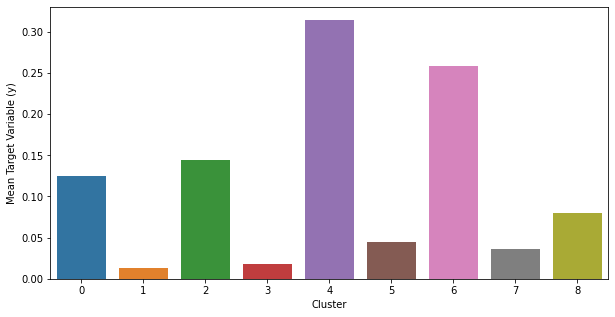

In [18]:
#finding cluster that correspond to y_train_cool = 1
import matplotlib.pyplot as plt
import seaborn as sns

cluster_mean = pd.DataFrame(data={"Cluster": gmm.predict(X_train_cool), "Mean Target Variable (y)": y_train_cool}).groupby("Cluster").mean().reset_index(drop=False)
plt.figure(figsize=(10, 5))
sns.barplot(data=cluster_mean, x="Cluster", y="Mean Target Variable (y)")
plt.show()

In [21]:
#sampling 1500000 samples from GMMs cluster 2
samples, clusters = gmm.sample(350000)
samples_to_keep = samples[clusters==4]

In [22]:
#new sample for X_train_cool for y = 1
X_train_cool_y1 = pd.DataFrame(samples_to_keep, columns=X_train_cool.columns)
X_train_cool_y1.shape

(15361, 13)

In [23]:
#new sample for y_train_cool having y = 1
y1 = []
for i in range(15361):
  y1.append(1)

y_train_cool_y1 = pd.Series(y1)
y_train_cool_y1.shape

(15361,)

In [24]:
X_train_cool.shape

(37193, 13)

In [25]:
y_train_cool.shape

(37193,)

In [26]:
#new X_train_cool and y_train_cool
X_train_cool_bal = pd.concat([X_train_cool, X_train_cool_y1])
y_train_cool_bal = pd.concat([y_train_cool, y_train_cool_y1])

In [27]:
X_train_cool_bal.shape

(52554, 13)

In [28]:
y_train_cool_bal.shape

(52554,)

In [29]:
#@title Logistic Regression to predict cooling behavior

In [30]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_cool_bal, y_train_cool_bal)
log_reg.score(X_test_cool, y_test_cool)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8985912463705775

In [31]:
#logistic regression coefficients
log_reg.coef_

array([[-1.67130622e-01, -5.07601878e-02,  4.30831638e-04,
         3.09272329e-02,  2.53121337e-01, -5.82526154e-02,
        -1.35549282e-02,  2.98671438e-04, -4.56593324e-02,
        -7.93443633e-02,  9.14609317e-03,  7.93338649e-03,
        -1.60114547e-04]])

In [32]:
table = pd.DataFrame(log_reg.coef_, columns=X_cool.columns)
table1 = table.transpose()
table1

,0
IndoorTemperature,-0.167131
IndoorHumidity,-0.050760
IndoorCO2,0.000431
IndoorNoise,0.030927
OutdoorTemperature,0.253121
OutdoorHumidity,-0.058253
OutdoorDewpoint,-0.013555
OutdoorWindDirection,0.000299
OutdoorWindSpeed,-0.045659
OutdoorGustSpeed,-0.079344


In [33]:
#@title Apply SVM to cooling dataset

In [34]:
from sklearn import svm

svm_cool = svm.SVC(kernel='rbf', C=0.01) #linear and C=1 did not work
svm_cool.fit(X_train_cool_bal, y_train_cool_bal)
svm_cool.score(X_test_cool, y_test_cool)

0.8505215614582213

In [35]:
#@title Applying Decision Trees to cooling dataset

In [36]:
from sklearn.tree import DecisionTreeClassifier

dtree_cool = DecisionTreeClassifier()
dtree_cool.fit(X_train_cool_bal, y_train_cool_bal)
dtree_cool.score(X_test_cool, y_test_cool)

0.955909237552425

[Text(0.4230769230769231, 0.875, 'OutdoorHumidity <= 31.984\ngini = 0.452\nsamples = 52554\nvalue = [34456, 18098]'),
 Text(0.15384615384615385, 0.625, 'Precipitation <= -0.0\ngini = 0.161\nsamples = 17362\nvalue = [1528, 15834]'),
 Text(0.07692307692307693, 0.375, 'gini = 0.0\nsamples = 7583\nvalue = [0, 7583]'),
 Text(0.23076923076923078, 0.375, 'Precipitation <= 0.0\ngini = 0.264\nsamples = 9779\nvalue = [1528, 8251]'),
 Text(0.15384615384615385, 0.125, '\n  (...)  \n'),
 Text(0.3076923076923077, 0.125, '\n  (...)  \n'),
 Text(0.6923076923076923, 0.625, 'OutdoorTemperature <= 21.597\ngini = 0.12\nsamples = 35192\nvalue = [32928, 2264]'),
 Text(0.5384615384615384, 0.375, 'OutdoorDewpoint <= 12.818\ngini = 0.043\nsamples = 28331\nvalue = [27701, 630]'),
 Text(0.46153846153846156, 0.125, '\n  (...)  \n'),
 Text(0.6153846153846154, 0.125, '\n  (...)  \n'),
 Text(0.8461538461538461, 0.375, 'IndoorNoise <= 59.158\ngini = 0.363\nsamples = 6861\nvalue = [5227, 1634]'),
 Text(0.7692307692307

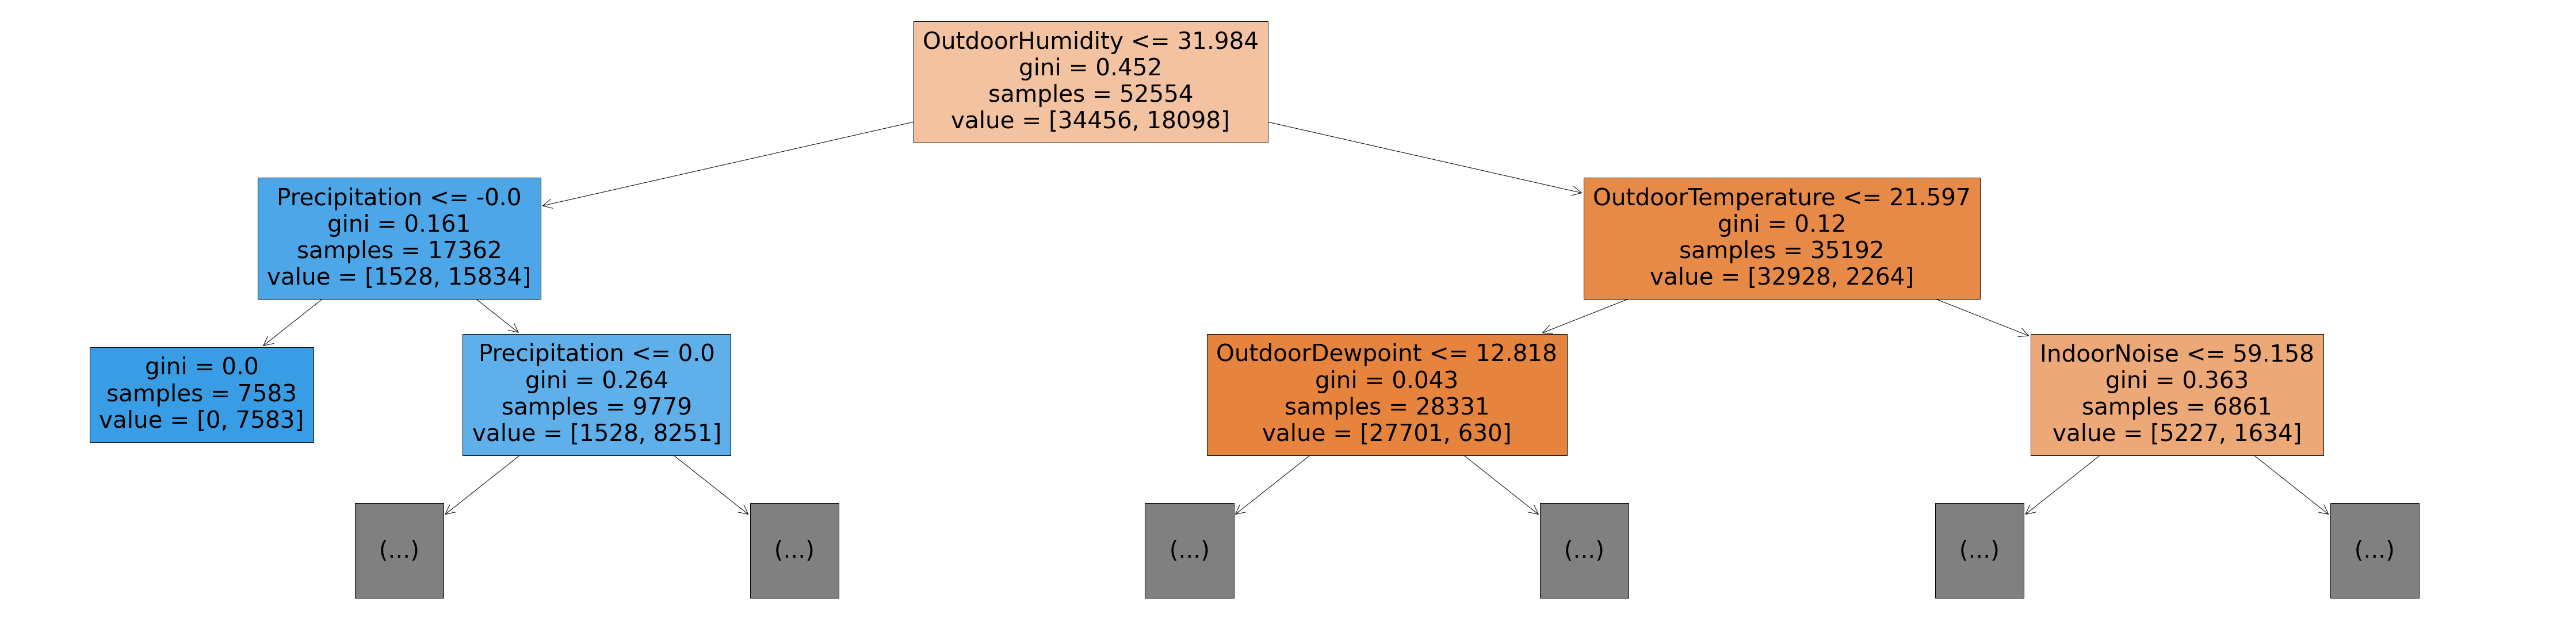

In [38]:
#plotting the tree
from sklearn.tree import plot_tree, export_text
plt.figure(figsize =(80,20))

plot_tree(dtree_cool, feature_names=X_train_cool_bal.columns, max_depth=2, filled=True)

In [39]:
#@title Applying GMMs to balance the heating dataset

In [40]:
#test train split the heating dataset
from sklearn.model_selection import train_test_split
X_heat = df_heat.iloc[:, :-1]
y_heat = df_heat['HeatingState']

X_train_heat, X_test_heat, y_train_heat, y_test_heat = train_test_split(X_heat, y_heat, test_size=0.2, shuffle=True)

In [41]:
#applying GMMs to balance heating dataset
from sklearn.mixture import GaussianMixture

lowest_aic = np.infty
aic = []
n_components_range = range(1, 50)

for n_components in n_components_range:
        # Fit a Gaussian mixture with component range
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(X_train_heat)
        aic.append(gmm.aic(X_train_heat))
        if aic[-1] < lowest_aic:
            lowest_aic = aic[-1]
            best_gmm = gmm

print(lowest_aic)
print(best_gmm.n_components)

/usr/local/lib/python3.8/dist-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


1981799.5788423284
48


In [42]:
#checking the 8 clusters
gmm = GaussianMixture(48)
gmm.fit(X_train_heat)
pd.DataFrame(gmm.means_.T)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,21.948461,18.404404,18.411735,18.058212,21.746354,25.557461,20.752806,21.092366,23.040995,24.311894,...,24.725806,20.203868,21.653458,25.118369,22.406467,25.060434,23.864426,22.670965,21.221782,21.251968
1,61.767869,59.871353,58.131894,60.451277,60.235044,44.752645,58.440348,53.604394,67.561478,50.579043,...,57.903226,60.187142,54.308847,41.173469,57.704250,45.608199,60.911366,63.483892,58.129296,69.176889
2,1806.650122,1859.592357,601.363071,1558.277856,5000.000000,1425.608502,1157.706535,1417.484243,1869.085761,4124.643856,...,3107.612903,2143.525908,1220.022253,1524.086439,2143.500402,2463.030055,3064.962533,2269.935370,1050.804376,786.153880
3,55.705098,57.081004,52.985406,55.999807,61.869668,57.735054,54.694087,53.619436,60.475718,56.582183,...,68.193548,59.505411,53.398773,59.551018,59.895516,60.028013,68.793456,67.935489,56.683833,52.950289
4,18.712558,12.388828,16.636435,12.074920,17.851593,35.819076,17.514805,20.464012,19.613045,27.445636,...,14.960753,15.674286,23.221200,35.132321,20.283541,30.043461,19.410933,27.505313,18.324591,17.981301
5,57.804563,75.196030,67.161103,77.386029,57.815916,17.430939,64.380862,42.381485,90.514048,32.404182,...,69.451613,71.083476,42.155787,17.966836,59.953236,33.036460,82.308604,38.774215,68.023306,97.411590
6,9.810654,8.113686,10.417477,8.217283,8.487978,7.198213,10.697209,7.176169,18.031365,7.605675,...,9.316452,10.434817,9.622944,7.179847,12.221974,7.533955,16.232501,11.909197,12.311742,17.572799
7,236.843754,106.193868,88.188496,201.621491,173.238572,131.490899,184.061759,296.445153,243.835296,192.820843,...,133.064516,209.209925,205.486971,45.000000,226.185781,196.781216,226.329302,76.935463,179.975527,226.710829
8,3.658922,1.277292,0.858202,2.704404,2.010763,3.135632,1.717365,3.283584,0.789024,1.653705,...,1.621505,2.437526,1.543947,4.646683,1.440940,3.086509,1.526557,2.008063,1.333067,1.789192
9,4.839569,1.799012,1.202435,3.727964,2.749084,4.411644,2.272855,4.514112,1.012632,2.298099,...,2.081720,3.323146,2.091160,6.479591,1.987047,4.363061,1.944229,2.933869,1.785431,2.346292


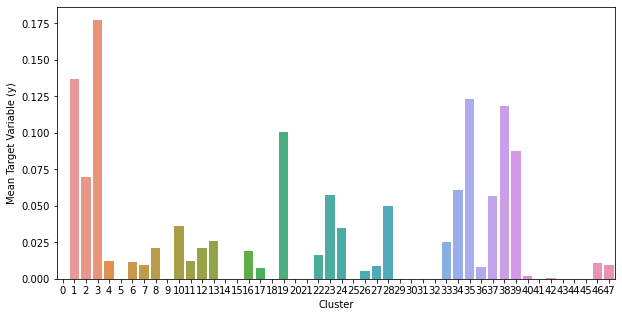

In [43]:
#finding cluster that correspond to y_train_heat = 1
import matplotlib.pyplot as plt
import seaborn as sns

cluster_mean = pd.DataFrame(data={"Cluster": gmm.predict(X_train_heat), "Mean Target Variable (y)": y_train_heat}).groupby("Cluster").mean().reset_index(drop=False)
plt.figure(figsize=(10, 5))
sns.barplot(data=cluster_mean, x="Cluster", y="Mean Target Variable (y)")
plt.show()

In [48]:
#sampling 15000000 samples from GMMs cluster 18
samples, clusters = gmm.sample(1500000)
samples_to_keep = samples[clusters==3]

In [49]:
#new sample for X_train_heat for y = 1
X_train_heat_y1 = pd.DataFrame(samples_to_keep, columns=X_train_heat.columns)
X_train_heat_y1.shape

(14164, 13)

In [50]:
#new sample for y_train_heat having y = 1
y1 = []
for i in range(14164):
  y1.append(1)

y_train_heat_y1 = pd.Series(y1)
y_train_heat_y1.shape

(14164,)

In [60]:
#new X_train_heat and y_train_heat
X_train_heat_bal = pd.concat([X_train_heat, X_train_heat_y1])
y_train_heat_bal = pd.concat([y_train_heat, y_train_heat_y1])

In [52]:
#@title Logistic Regression to predict heating behavior

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

log_reg = LogisticRegression()
log_reg.fit(X_train_heat_bal, y_train_heat_bal)
log_reg.score(X_test_heat, y_test_heat)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8983761694805893

In [54]:
#logistic regression coefficients
log_reg.coef_

array([[ 4.34830843e-02, -3.92641942e-02,  2.10175957e-04,
        -1.16549299e-02, -4.28488258e-01,  1.33582808e-01,
        -3.04565130e-01, -3.15257621e-03,  2.11147812e-01,
         2.88442003e-01,  1.67499244e-02, -1.72930189e-02,
        -7.15524362e-04]])

In [56]:
list = [4.34830843e-02, -3.92641942e-02,  2.10175957e-04,
        -1.16549299e-02, -4.28488258e-01,  1.33582808e-01,
        -3.04565130e-01, -3.15257621e-03,  2.11147812e-01,
         2.88442003e-01,  1.67499244e-02, -1.72930189e-02,
        -7.15524362e-04]

In [57]:
table = pd.DataFrame(list, index=X_cool.columns)
table

,0
IndoorTemperature,0.043483
IndoorHumidity,-0.039264
IndoorCO2,0.000210
IndoorNoise,-0.011655
OutdoorTemperature,-0.428488
OutdoorHumidity,0.133583
OutdoorDewpoint,-0.304565
OutdoorWindDirection,-0.003153
OutdoorWindSpeed,0.211148
OutdoorGustSpeed,0.288442


In [ ]:
#@title Applying SVM to heating dataset

In [61]:
from sklearn import svm

svm_heat = svm.SVC(kernel='rbf', C=0.01) #linear and C=1 did not work
svm_heat.fit(X_train_heat_bal, y_train_heat_bal)
svm_heat.score(X_test_heat, y_test_heat)

0.9068717066351221

In [ ]:
#@title Applying Decision Trees to heating dataset

In [62]:
from sklearn.tree import DecisionTreeClassifier

dtree_heat = DecisionTreeClassifier()
dtree_heat.fit(X_train_heat_bal, y_train_heat_bal)
dtree_heat.score(X_test_heat, y_test_heat)

0.9664480051618454

[Text(0.4230769230769231, 0.875, 'Precipitation <= 0.0\ngini = 0.419\nsamples = 51357\nvalue = [36036, 15321]'),
 Text(0.15384615384615385, 0.625, 'Precipitation <= -0.0\ngini = 0.151\nsamples = 37709\nvalue = [34598, 3111]'),
 Text(0.07692307692307693, 0.375, 'gini = 0.0\nsamples = 2041\nvalue = [0, 2041]'),
 Text(0.23076923076923078, 0.375, 'OutdoorTemperature <= 14.488\ngini = 0.058\nsamples = 35668\nvalue = [34598, 1070]'),
 Text(0.15384615384615385, 0.125, '\n  (...)  \n'),
 Text(0.3076923076923077, 0.125, '\n  (...)  \n'),
 Text(0.6923076923076923, 0.625, 'OutdoorDewpoint <= 14.26\ngini = 0.189\nsamples = 13648\nvalue = [1438, 12210]'),
 Text(0.5384615384615384, 0.375, 'Precipitation <= 0.3\ngini = 0.087\nsamples = 12773\nvalue = [584, 12189]'),
 Text(0.46153846153846156, 0.125, '\n  (...)  \n'),
 Text(0.6153846153846154, 0.125, '\n  (...)  \n'),
 Text(0.8461538461538461, 0.375, 'SolarRadiation <= 438.61\ngini = 0.047\nsamples = 875\nvalue = [854, 21]'),
 Text(0.7692307692307693,

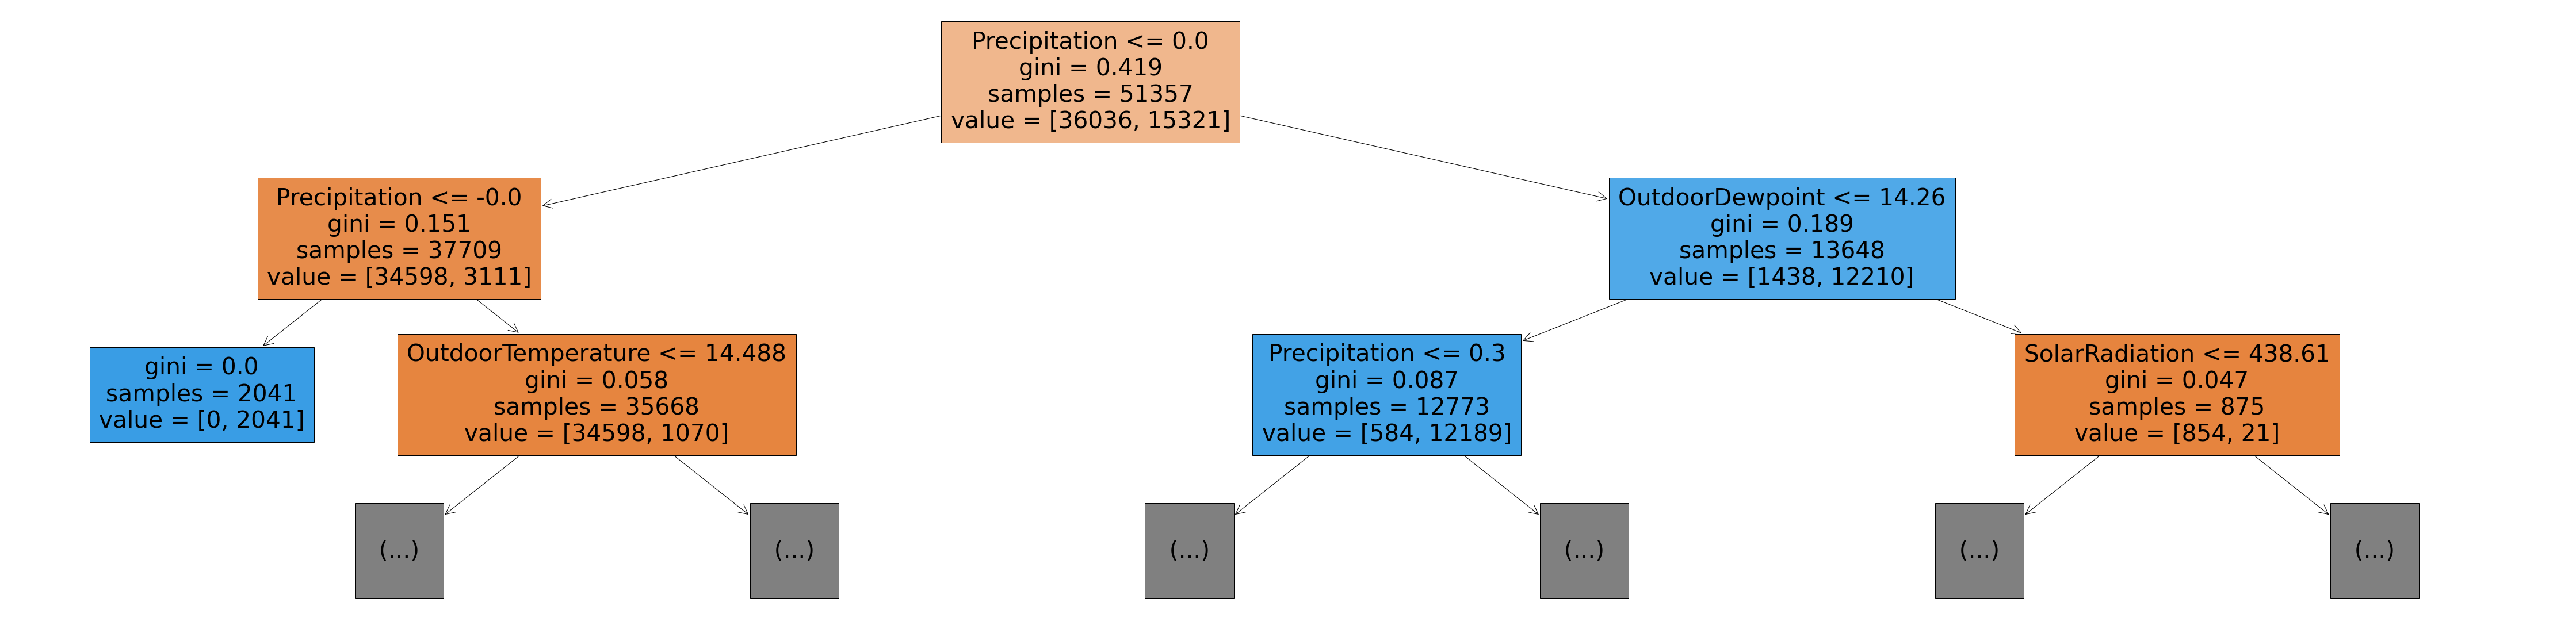

In [63]:
#plotting the tree
from sklearn.tree import plot_tree, export_text
plt.figure(figsize =(80,20))

plot_tree(dtree_heat, feature_names=X_train_heat_bal.columns, max_depth=2, filled=True)